In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<br><br>
# Bonnes pratiques : l'analyse de sensibilité sur python avec SALib
# Good practices : sensitivity analysis with python with SALib
Written by Sarah Juricic
<br>
Semptember 21st 2018
<br><br>
***

## Objectives : with this notebook you will
#### - understand the very basics of a sensitivity analysis and the specificity of an RBD-FAST analysis
#### - use on your own the python library SALib to perform an RBD-FAST analysis

***
<br><br>
**NOTE** : for more detail on sensitivity analysis in general, refer to the café focus by Jeanne Goffart (april 2017), presentation is on the server.
<br>
**CAUTION** : the sensitivity analysis tools should be used and analyzed with care. Without proper design, you won't be able to draw any conclusions at all, or worse, draw wrong conclusions...

<br>

## Introduction : how RBD-FAST (and sensitivity analysis in general) works

<br><br>


<br><br><br>
<img src="Principle SAnalysis.pdf" alt="oops! missing picture" title="basic principle" />
<br><br><br>

### RBD-FAST principle explained in Goffart, Rabouille and Mendes (2015)
<br><br><br>
<img src="RBD-FAST chez Goffart et al 2015.png" alt="oops! missing picture" title="RBD-FAST method in more detail" />
<br><br><br>



# GENERAL WORKFLOW

<br><br><br>
**1. define the "problem" dictionnary that states the number of inputs, their names, their bounds : prerequisite to SALib**
<br>
**2. sample values for each parameters in the space you want to study (through LHS sampler of SALib)**
<br>
**3. run your model/workflow and save the output(s) you're interested in (your own code)**
<br>
**4. use a SA method (from SALib analyze tools)**
<br>
and a **surpriiiise** !
<br><br>



## 1. Define the "problem dictionnary"

<br><br>

It is a regular python dictionnary object with mandatory keys :
- 'num_vars'
- 'names'
- 'bounds'

<br><br><br>

** TRICKY ALERT** Defining the bounds is one of the trickiest part of a sensitivity analysis

<br>Do read the literature on that subject, what your fellow researchers have set as bounds for their studies etc...
<br><br>
Here we have chosen to focus on a specific area of all the possible values taken by the parameters : ∓ 10% around a value.

In [2]:
# STATE THE PROBLEM DICTIONNARY
#what will be varying (=inputs) ? in what bounds ?

problem = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}



## 2. Draw a number of samples from your problem definition

<br><br>


In [3]:
# say we want to draw 150 samples

num_samples = 150

In [4]:
# we draw a Latin Hypercube Sampling (LHS) that is fitted for an RBD FAST analysis
#(other sampling metods available in the library though)

from SALib.sample.latin import *

all_samples = sample(problem, num_samples)
all_samples

array([[  1.69289395e+00,  -1.08462865e+00,   1.70244875e+00],
       [  4.45886384e-01,  -1.77685586e+00,   2.43773168e+00],
       [  7.85831866e-01,   8.16854048e-01,  -7.03884834e-01],
       [ -1.68096900e+00,   1.57387405e+00,  -1.29393913e+00],
       [ -1.93142787e-01,  -2.59777269e+00,  -1.92138218e-01],
       ...
       [  3.65858935e-01,   1.11775206e+00,   1.24117173e+00],
       [ -2.51616871e+00,   2.55344678e+00,  -2.34075548e+00]])

In [5]:
# fyi all_samples is a numpy array of following shape
all_samples.shape

(150, 3)



## 3. Run your own model/workflow to get the output of interest

<br><br>


<br>
Here, you use your own code, can be a python code like here, can call any other program (dymola, energy-plus, etc...)
<br>
***
We use a lumped thermal model, aka RC model.
<br>
<br>
<br>
**The scientific question behind** (it's not just a stupid example ^^) : can the model be entirely calibrated ?
- the parameters that have not influence on the output (indoor temperature) cannot be determined by any calibration algorithm
- and it's also ok, it means that we can just fix its value without interfering with the calibration process, and it reduces the dimensions of the inverse problem --> also good !

In [6]:
# this is where you define your own model, procedure, experiment...
from SALib.test_functions import Ishigami
import math

def run_model(a_sample):
    """
    COPY HERE YOUR OWN CODE
    
    the function takes as input 1 sample
    returns 1 or more output
    """
    
    # Delete from HERE =======================================
    
    # As an example, we'll look at the famous Ishigami function
    #(A and B are specific parameters for the Ishigami function)
    A = 7
    B = 0.1
    output_for_SA = math.sin(a_sample[0]) + A * math.pow(math.sin(a_sample[1]), 2) + \
            B * math.pow(a_sample[2], 4) * math.sin(a_sample[0])
        
    # ========= TO HERE and replace with your own piece of code
    
    return output_for_SA

**NOTE** : you could also use outputs from a different program, you would then have to upload your data into a python numpy array.

In [7]:
#store the about-to-be-calculated output for the SA in this array :
outputs_for_SA = np.zeros(num_samples)

# run your model, procedure, experiment for each sample of your sampling
for s,sample in enumerate(all_samples):
    outputs_for_SA[s] = run_model(sample)

In [8]:
# fyi
outputs_for_SA.shape

(150,)



## 4. SALib analysis tools

<br><br>

SALib is a python based library to perform sensitivity analysis.
<br>
So far, it contains the following analysis tools : 
- FAST - Fourier Amplitude Sensitivity Test
- RBD-FAST - Random Balance Designs Fourier Amplitude Sensitivity Test
- Method of Morris
- Sobol Sensitivity Analysis
- Delta Moment-Independent Measure
- Derivative-based Global Sensitivity Measure (DGSM)
- Fractional Factorial


<br><br>
#### RBD-FAST
**Reminder : Why do we want to use RBD-FAST ??**
- not only does it robustly calculates sensitvity indices as accurately as a Sobol method with much fewer samples
- but also it is based on a LH sampling : the output itself is exploitable and interesting to look at (unlike Morris method where the samples used for the calculation of the indices are useless afterwards).
<br><br>

In [9]:
from SALib.analyze import rbd_fast

In [10]:
# Let us look at the analyze method

rbd_fast.analyze(problem=problem, Y=outputs_for_SA, X=all_samples)

{'S1': [0.305553285241071, 0.47175910511096636, -0.070095132651744912]}

It is a dictionnary with a single key 'S1', corresponding to a list of 6 items.
<br>
**--> First order indices of all 6 input variables**

In [11]:
# storing the first order indices of the analyze method
si1 = rbd_fast.analyze(problem=problem, Y=outputs_for_SA, X=all_samples)['S1']

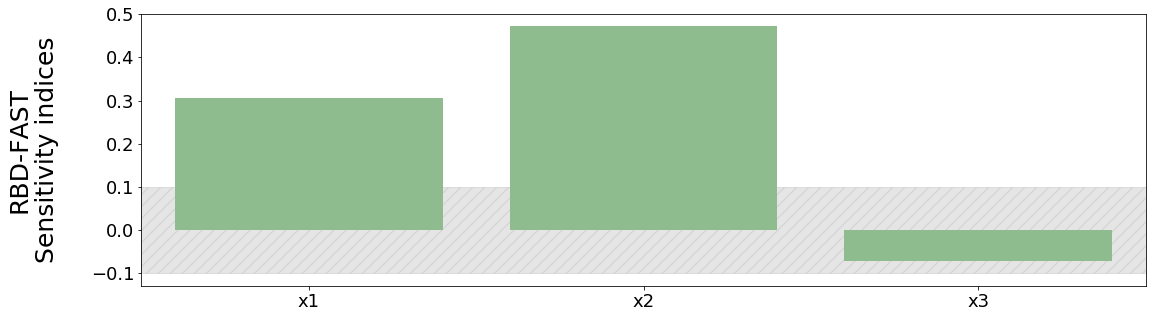

In [12]:
# make nice plots with the indices (looks good on your presentations)
# do not use the plotting tools of SALib, they are made for the method of Morris ...

fig, ax = plt.subplots()
fig.set_size_inches(18,5)

ax.tick_params(labelsize=18)

# ===== X-AXIS =====
ax.set_xticks(np.arange(problem['num_vars']))
ax.set_xticklabels(problem['names'])
ax.set_xlim(xmin=-0.5, xmax=problem['num_vars'] - 0.5)

# ===== Y-AXIS =====
ax.set_ylabel('RBD-FAST\nSensitivity indices\n', fontsize=25)

# ===== BARS REPRESENTING THE SENSITIVITY INDICES =====
ax.bar(np.arange(problem['num_vars']), si1,
         color='DarkSeaGreen');

#in striped grey : not significant indices 
ax.fill_between(x=[-0.5, 5.5], y1=-0.1, y2=0.1, color='grey', alpha=0.2, hatch='//', edgecolor='white');

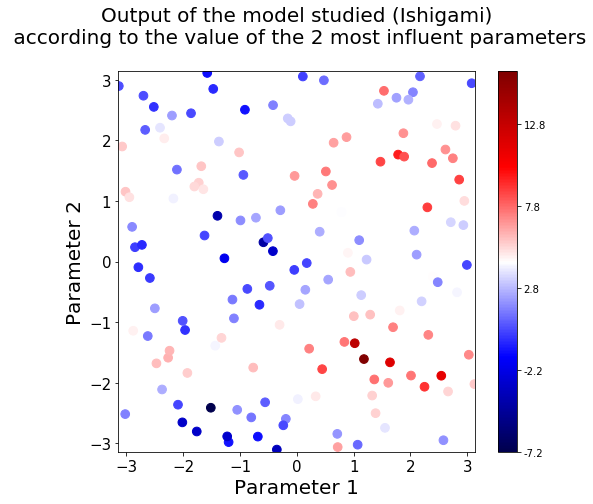

In [13]:
# take a closer look to undestand interactions (looks even better on your presentations)
# this part can be done without analyzing with SALib, just with the ouput from the samples

fig, ax = plt.subplots()
fig.set_size_inches(8,7)

ax.tick_params(labelsize=15)
ax.set_title('Output of the model studied (Ishigami)\n according to the value of the 2 most influent parameters\n',
            fontsize=20)

# ===== SCATTER =====
size = np.ones(num_samples) * 75

sc = ax.scatter(all_samples[:,0], all_samples[:,1],
                c=outputs_for_SA,
                s=size,
                vmin=outputs_for_SA.min(),
                vmax=outputs_for_SA.max(),
                cmap='seismic',
                edgecolor=None)


# ===== X-AXIS =====
ax.set_xlim(xmin=problem['bounds'][0][0], xmax=problem['bounds'][0][1])
ax.set_xlabel('Parameter 1', fontsize=20)


# ===== Y-AXIS =====
ax.set_ylim(ymin=problem['bounds'][1][0], ymax=problem['bounds'][1][1])
ax.set_ylabel('Parameter 2', fontsize=20)

# ===== COLORBAR =====
ticks = np.arange(outputs_for_SA.min(), outputs_for_SA.max(), 5)
cb = plt.colorbar(sc, ticks=ticks);
cb.ax.set_yticklabels([str(round(i,1)) for i in ticks]);

Event without running the sensitivity analysis with the analyze module, this graph shows us some strong non-linearities (where blue is very near red). This only tells us that we should study this model with more samples, 150 is not enough.



## Surprise 5th module
    
## Basic convergence check : NOT in SALib BUT definitely mandatory

<br><br>

**Principle** Perform the SA from a sub-sample of 50, 60, 70, ... up to the total 300. We should see that the indices stabilize around a value. If not, we need more samples !

In [14]:
# calculate
all_indices = []

for n in range(50,num_samples+1,10):
    # take n samples among the num_samples, without replacement
    subset = np.random.choice(num_samples, size=n, replace=False)
    all_indices.append(rbd_fast.analyze(problem=problem, Y=outputs_for_SA[subset], X=all_samples[subset])['S1'])
    
all_indices = np.array(all_indices)

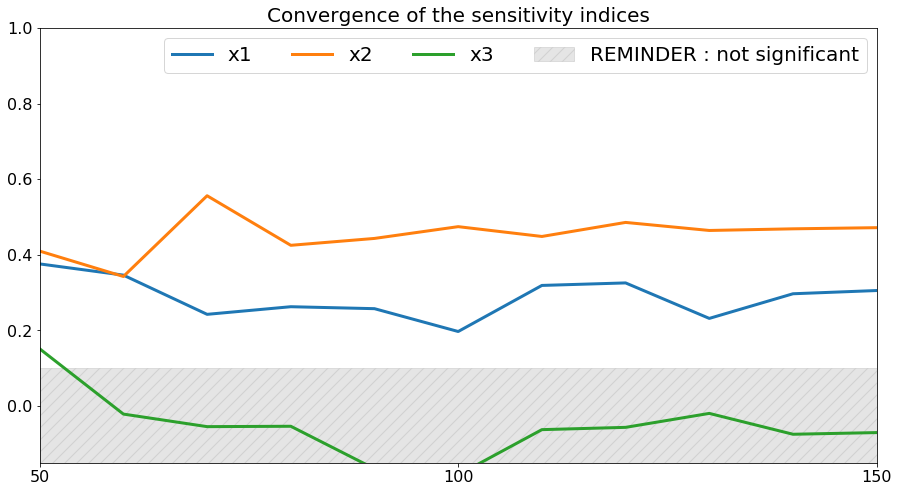

In [15]:
# convergence check
fig, ax = plt.subplots()
fig.set_size_inches(15,8)

ax.set_title('Convergence of the sensitivity indices', fontsize=20)

ax.tick_params(labelsize=16)

ax.set_xlim(xmin=0, xmax=(num_samples - 50)//10)
ax.set_xticks(np.arange(0,(num_samples - 50)//10 +1,5))
ax.set_xticklabels([str(i) for i in range(50,num_samples+1,50)])

ax.set_ylim(ymin=-0.15, ymax=1)


for p,param in enumerate(problem['names']):
    ax.plot(all_indices[:,p], linewidth=3, label=param)

ax.fill_between(x=[0,(num_samples - 50)//10], y1=-0.15, y2=0.1, color='grey', alpha=0.2, hatch='//', edgecolor='white',
              label='REMINDER : not significant')
    
ax.legend(fontsize=20, ncol=4);

<br><br>
**Last but not least the BOOTSTRAP principle** : select a subset of n_sub samples, with n_sub < num_samples (say on 200 over 300) and perform the sensitivity analysis on that subset. Repeat 1000 times that operation. The indices will vary : the bigger they vary the larger the influence of the samples (aka some of the samples influence greatly the outcome of the SA).
<br>The indices are trustworthy if the indices show robustness in the bootstrap process.

In [16]:
def bootstrap(problem, Y, X):
    """
    Calculate confidence intervals of rbd-fast indices
    1000 draws
    returns 95% confidence intervals of the 1000 indices
    
    problem : dictionnary as SALib uses it
    X : SA input(s)
    Y : SA output(s)
    """
    all_indices = []
    
    for i in range(1000):
        X_new = np.zeros(X.shape)
        Y_new = np.zeros(Y.shape).flatten()
        # draw with replacement
        tirage_indices = np.random.randint(0, high=Y.shape[0], size = Y.shape[0])
        
        for j, index in enumerate(tirage_indices):
            X_new[j,:] = X[index, :]
            Y_new[j] = Y[index]
            
        all_indices.append(rbd_fast.analyze(problem=problem, Y=Y_new, X=X_new)['S1'])
    
    means = np.array([i.mean() for i in np.array(all_indices).T])
    stds = np.array([i.std() for i in np.array(all_indices).T])
    return np.array([means - 2 * stds, means + 2 * stds])

In [17]:
# Get bootstrap confidence intervals for each index

bootstrap_conf = bootstrap(problem=problem, Y=outputs_for_SA, X=all_samples)


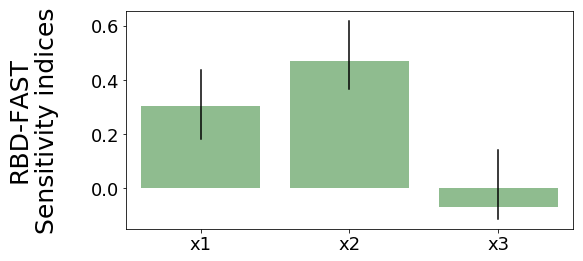

In [18]:
# make nice plots with the indices (looks good on your presentations)
# do not use the plotting tools of SALib, they are made for the method of Morris ...

fig, ax = plt.subplots()
fig.set_size_inches(8,4)

ax.tick_params(labelsize=18)

# ===== X-AXIS =====
ax.set_xticks(np.arange(problem['num_vars']))
ax.set_xticklabels(problem['names'])
ax.set_xlim(xmin=-0.5, xmax=problem['num_vars'] - 0.5)

# ===== Y-AXIS =====
ax.set_ylabel('RBD-FAST\nSensitivity indices\n', fontsize=25)

# ===== BARS REPRESENTING THE SENSITIVITY INDICES =====
ax.bar(np.arange(problem['num_vars']), si1,
         color='DarkSeaGreen');

# ===== LINES REPRESENTING THE BOOTSTRAP "CONFIDENCE INTERVALS" =====
for j in range(problem['num_vars']):
    ax.plot([j, j], [bootstrap_conf[0, j], bootstrap_conf[1, j]],
              'k')

#ax.fill_between(x=[-0.5, 5.5], y1=-0.1, y2=0.1, color='grey', alpha=0.2, hatch='//', edgecolor='white');

**Comment** below 0.1 is not significant also because the bootstrap shows a standard deviation of +- 0.1



## Lucky you, some references for you to nerd with

<br><br>
S. Tarantola, D. Gatelli and T. Mara (2006) “Random Balance Designs for the Estimation of First Order Global Sensitivity Indices”, Reliability Engineering and System Safety, 91:6, 717-727
<br><br>
Elmar Plischke (2010) “An effective algorithm for computing global sensitivity indices (EASI) Reliability Engineering & System Safety”, 95:4, 354-360. doi:10.1016/j.ress.2009.11.005
<br><br>
Jean-Yves Tissot, Clémentine Prieur (2012) “Bias correction for the estimation of sensitivity indices based on random balance designs.”, Reliability Engineering and System Safety, Elsevier, 107, 205-213. doi:10.1016/j.ress.2012.06.010
<br><br>
Jeanne Goffart, Mickael Rabouille & Nathan Mendes (2015) “Uncertainty and sensitivity analysis applied to hygrothermal simulation of a brick building in a hot and humid climate”, Journal of Building Performance Simulation. doi:10.1080/19401493.2015.1112430
<br><br>
Jeanne Goffart, Monika Woloszyn (2018) RBD-FAST : une méthode d’analyse de sensibilité rapide et rigoureuse pour la thermique du bâtiment, IBPSA France, Bordeaux



## Your turn now ! Because it doesn't look very well with 150 samples...

<br>
- try 250, 500, or 1000 ?
- Do the indices change?
- How does the convergence look like?
- and the bootstrap "confidence intervals" ?